<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv', parse_dates=['dates'],  index_col='dates',infer_datetime_format=True)
df.drop(['Unnamed: 0', 'Purity'], axis=1, inplace=True)

In [25]:
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [26]:
WINDOW_SIZE = 5
X, y = df_to_X_y(df['% Silica Concentrate'], WINDOW_SIZE)
X.shape, y.shape

((3800, 5, 1), (3800,))

In [27]:
X_train, y_train = X[:2000], y[:2000]
X_val, y_val = X[2000:3500], y[2000:3500]
X_test, y_test = X[3500:], y[3500:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((2000, 5, 1), (2000,), (1500, 5, 1), (1500,), (300, 5, 1), (300,))

In [28]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, InputLayer
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(InputLayer((5, 1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [29]:
cp = ModelCheckpoint('model1/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0025), metrics=[RootMeanSquaredError()])

In [30]:
model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50,
          callbacks=[cp])

Epoch 1/50
60/63 [===========================>..] - ETA: 0s - loss: 1.7503 - root_mean_squared_error: 1.3230

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 8s 99ms/step - loss: 1.7014 - root_mean_squared_error: 1.3044 - val_loss: 0.6980 - val_root_mean_squared_error: 0.8355
Epoch 2/50
54/63 [========================>.....] - ETA: 0s - loss: 0.5228 - root_mean_squared_error: 0.7231

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 5s 88ms/step - loss: 0.5230 - root_mean_squared_error: 0.7232 - val_loss: 0.6002 - val_root_mean_squared_error: 0.7747
Epoch 3/50
57/63 [==========================>...] - ETA: 0s - loss: 0.4587 - root_mean_squared_error: 0.6773

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 5s 83ms/step - loss: 0.4472 - root_mean_squared_error: 0.6687 - val_loss: 0.5839 - val_root_mean_squared_error: 0.7641
Epoch 4/50
62/63 [============================>.] - ETA: 0s - loss: 0.4321 - root_mean_squared_error: 0.6574

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 6s 91ms/step - loss: 0.4329 - root_mean_squared_error: 0.6580 - val_loss: 0.5479 - val_root_mean_squared_error: 0.7402
Epoch 5/50
59/63 [===========================>..] - ETA: 0s - loss: 0.3985 - root_mean_squared_error: 0.6313

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 5s 82ms/step - loss: 0.4002 - root_mean_squared_error: 0.6326 - val_loss: 0.5336 - val_root_mean_squared_error: 0.7305
Epoch 6/50
63/63 [==============================] - 1s 8ms/step - loss: 0.3924 - root_mean_squared_error: 0.6264 - val_loss: 0.5804 - val_root_mean_squared_error: 0.7619
Epoch 7/50
60/63 [===========================>..] - ETA: 0s - loss: 0.3838 - root_mean_squared_error: 0.6195

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 6s 90ms/step - loss: 0.3913 - root_mean_squared_error: 0.6255 - val_loss: 0.5292 - val_root_mean_squared_error: 0.7275
Epoch 8/50
60/63 [===========================>..] - ETA: 0s - loss: 0.3744 - root_mean_squared_error: 0.6119

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 5s 83ms/step - loss: 0.3797 - root_mean_squared_error: 0.6162 - val_loss: 0.5211 - val_root_mean_squared_error: 0.7219
Epoch 9/50
63/63 [==============================] - 0s 8ms/step - loss: 0.3835 - root_mean_squared_error: 0.6193 - val_loss: 0.5484 - val_root_mean_squared_error: 0.7406
Epoch 10/50
61/63 [============================>.] - ETA: 0s - loss: 0.3874 - root_mean_squared_error: 0.6224

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 5s 89ms/step - loss: 0.3820 - root_mean_squared_error: 0.6180 - val_loss: 0.5195 - val_root_mean_squared_error: 0.7208
Epoch 11/50
54/63 [========================>.....] - ETA: 0s - loss: 0.3874 - root_mean_squared_error: 0.6224

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 5s 88ms/step - loss: 0.3812 - root_mean_squared_error: 0.6174 - val_loss: 0.5186 - val_root_mean_squared_error: 0.7202
Epoch 12/50
63/63 [==============================] - 0s 8ms/step - loss: 0.3804 - root_mean_squared_error: 0.6168 - val_loss: 0.5293 - val_root_mean_squared_error: 0.7275
Epoch 13/50
63/63 [==============================] - ETA: 0s - loss: 0.3784 - root_mean_squared_error: 0.6152

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 5s 81ms/step - loss: 0.3784 - root_mean_squared_error: 0.6152 - val_loss: 0.5160 - val_root_mean_squared_error: 0.7183
Epoch 14/50
63/63 [==============================] - 0s 7ms/step - loss: 0.3822 - root_mean_squared_error: 0.6182 - val_loss: 0.5192 - val_root_mean_squared_error: 0.7205
Epoch 15/50
63/63 [==============================] - ETA: 0s - loss: 0.3833 - root_mean_squared_error: 0.6191

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 6s 90ms/step - loss: 0.3833 - root_mean_squared_error: 0.6191 - val_loss: 0.5131 - val_root_mean_squared_error: 0.7163
Epoch 16/50
63/63 [==============================] - 0s 7ms/step - loss: 0.3780 - root_mean_squared_error: 0.6149 - val_loss: 0.5196 - val_root_mean_squared_error: 0.7208
Epoch 17/50
63/63 [==============================] - 0s 7ms/step - loss: 0.3910 - root_mean_squared_error: 0.6253 - val_loss: 0.5226 - val_root_mean_squared_error: 0.7229
Epoch 18/50
63/63 [==============================] - 0s 7ms/step - loss: 0.3870 - root_mean_squared_error: 0.6221 - val_loss: 0.5197 - val_root_mean_squared_error: 0.7209
Epoch 19/50
63/63 [==============================] - 0s 8ms/step - loss: 0.3781 - root_mean_squared_error: 0.6149 - val_loss: 0.5320 - val_root_mean_squared_error: 0.7294
Epoch 20/50
63/63 [==============================] - 0s 7ms/step - loss: 0.3823 - root_mean_squared_error: 0.6183 - val_loss: 0.5257 - val_root_mean_squared

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


63/63 [==============================] - 5s 83ms/step - loss: 0.3763 - root_mean_squared_error: 0.6134 - val_loss: 0.5114 - val_root_mean_squared_error: 0.7151
Epoch 45/50
63/63 [==============================] - 0s 7ms/step - loss: 0.3712 - root_mean_squared_error: 0.6093 - val_loss: 0.5179 - val_root_mean_squared_error: 0.7196
Epoch 46/50
63/63 [==============================] - 1s 8ms/step - loss: 0.3722 - root_mean_squared_error: 0.6101 - val_loss: 0.5123 - val_root_mean_squared_error: 0.7157
Epoch 47/50
63/63 [==============================] - 0s 7ms/step - loss: 0.3771 - root_mean_squared_error: 0.6141 - val_loss: 0.5631 - val_root_mean_squared_error: 0.7504
Epoch 48/50
63/63 [==============================] - 0s 8ms/step - loss: 0.3763 - root_mean_squared_error: 0.6135 - val_loss: 0.5215 - val_root_mean_squared_error: 0.7222
Epoch 49/50
63/63 [==============================] - 0s 8ms/step - loss: 0.3727 - root_mean_squared_error: 0.6105 - val_loss: 0.5140 - val_root_mean_squared

In [31]:
from tensorflow.keras.models import load_model
model = load_model('model1/')

train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

,Train Predictions,Actuals
0,1.533895,1.15
1,1.397537,2.76
2,2.399525,2.65
3,2.683745,1.73
4,1.895116,1.81
...,...,...
1995,1.692004,1.47
1996,1.619546,1.60
1997,1.722058,1.46
1998,1.646978,1.06


In [32]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

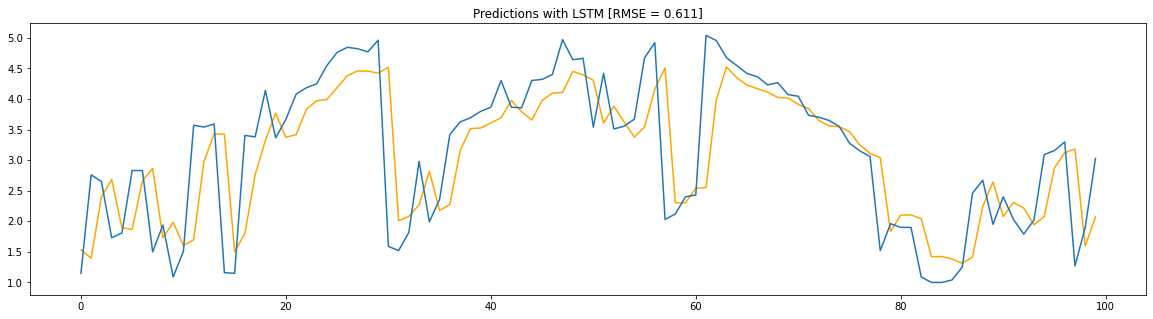

In [34]:
import matplotlib.pyplot as plt

mape, mae, rmse = forecast_accuracy(train_results['Train Predictions'], train_results['Actuals'])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(train_results['Train Predictions'][0:100], color='orange')
plt.plot(train_results['Actuals'][0:100])
plt.title("Predictions with LSTM [RMSE = %.3f]" % rmse)
plt.show()